# Lab 06 &mdash; $\chi^2$-test and non-parametric methods &mdash; practice


**Please enter in the cell below your first name, last name, and student ID**

* <b>Name: Alpesh Kumar
* Student ID: 100995076<b>

In [2]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

1. Consider the A/B testing data for the cookie cat game. Establish with a two-sided U test at level $0.05$ if there is a significant difference in the number of played game rounds (column `sum_gamerounds`) between the two versions of the game. To do so, draw a sample of 200 observations for each version of the game

In [3]:
# code for exercise 1
# fix random seed so that results are reproducible (do not change)
np.random.seed(42)

df_cookie = pd.read_csv("cookie_cats.csv")
df_cookie.head()

n = 200
cookie_1_contable = pd.crosstab(index=df_cookie.version, columns=df_cookie.sum_gamerounds)

gate30 = df_cookie.version == 'gate_30'
gate30_sample = gate30.sample(n)
gate40 = df_cookie.version == 'gate_40'
gate40_sample = gate40.sample(n)

U_stat, p_val = stats.mannwhitneyu(gate30_sample,gate40_sample,alternative='two-sided')
print("p-value (two versions of the game): "+str(p_val))

p-value (two versions of the game): 0.6898782731003986


<b>* We see that the p-value is much higher with the given level of 0.05, which would suggest absence of a difference between the two versions of the game
* The reason is that by taking independent observations, we introduce a lot of inter-subject variability
    * the variability of versions is very high, which makes it difficult to assess presence of an actual difference</b>

2. Using the *CDC's Behavioral Risk Factor Surveillance System (BRFSS) survey* dataset, establish whether there is a significant association between gender and smoking, using a $\chi^2$ test at level $0.05$ and a sample of 500 participants. Print to screen also the value of the test statistic and the p-value

In [15]:
# code for exercise 2
# fix random seed so that results are reproducible (do not change)
np.random.seed(42)

df_cdc = pd.read_csv("cdc.csv")
n = 500
cdc_sample = df_cdc.sample(n)
cdc_contable = pd.crosstab(index=cdc_sample.gender, columns=cdc_sample.smoke100)
chi2, p_val, dof, exp_counts = stats.chi2_contingency(cdc_contable, correction=False)
print("the value of the test statistic is "+str(chi2)+". p value is: "+str(p_val))
print("Degrees of freedom: "+str(dof))

the value of the test statistic is 7.045877981245304. p value is: 0.007944787145235391
Degrees of freedom: 1


<b>We see that the p-value is much smaller than the given level of 0.05, which would suggest absence of significant association between gender and smoking</b>

3. By adapting the code of the `sign_test` function (see lab notebook), define a function that performs hypothesis testing about any percentile (not just the median). Evaluate your function on a random sample of 100 observations from the `sum_gamerounds` variable of the cookie cat game. Compute the p-value for a two-sided test that the true 37% percentile is equal to 37.
    * the function should take in input three arguments: `sample`, `null_value`, and `q`, where `q` is the desired percentile (between 0 and 100)
    * so, the null hypothesis is that the true `q`-th percentile is `null_value`
    * _tip_: you'll just need to modify the distribution under the null

In [14]:
# code for exercise 3
# fix random seed so that results are reproducible (do not change)
np.random.seed(42)

#print(cookie_1_contable)
def sign_test(sample, q, m0=37):
    n = sample.size
    h0_distr = stats.binom(n=n, p = 1-q/100)
    num_wins = np.sum(sample>m0)
    num_ties = np.sum(sample==m0)
    stat_val = num_wins + stats.binom(n = num_ties, p = 0.5).rvs(1)
    left_tail_p = h0_distr.cdf(stat_val)
    right_tail_p = 1 - h0_distr.cdf(stat_val-1)
    p_val=2*np.min([left_tail_p,right_tail_p])
    return stat_val, p_val

n = 100
cookie_sgsample = df_cookie.sum_gamerounds.sample(n)

q = 37
stat_val, p_val = sign_test(cookie_sgsample, q)
print("Test statistic value (num of positive differences with random tie correction): "+ str(stat_val))
print("p-value: "+str(p_val))

Test statistic value (num of positive differences with random tie correction): [33]
p-value: 2.2959909398516337e-09


4. Perform the same test of question 3. using bootstrap sampling. I.e., draw a random sample of 50 observations from the `sum_gamerounds` variable. By resampling this sample, generate a bootstrap distribution for the 37-th percentile. Use $B=2000$ bootstrap samples. Finally, apply the shifting method to derive the null distribution and compute the p-value.
    * _tip_: percentiles can be computed using the `np.percentile` function, see lab notebook and https://numpy.org/doc/stable/reference/generated/numpy.percentile.html

In [16]:
# code for exercise 4
# fix random seed so that results are reproducible (do not change)
np.random.seed(42)

sample_size = 50
sample = df_cookie.sum_gamerounds.sample(sample_size)
q=np.percentile(sample,37)
pop_distr = stats.uniform(sample)

# our statistic is the IQR
# let's define a function handle for that
my_stat = lambda sample : stats.binom(n=sample_size, p=1-q/100).rvs(1)

# this is our sample estimate of the statistic
theta_hat_est = my_stat(sample)
print('Estimate of statistic on "sample" is: '+str(theta_hat_est))

Estimate of statistic on "sample" is: [43]


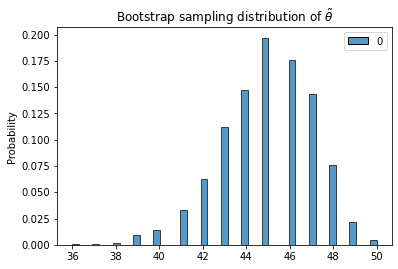

In [19]:
import seaborn as sns
# let's draw 2000 samples
sample_num = 2000
# initialize a numpy array of size (sample_num, 1) to store the sample statistics
theta_hats = np.empty([sample_num, 1])

# draw the samples by calling the rvs function
for i in range(sample_num):
    # apply our statistic function to a random sample drawn from the pop distr
    theta_hats[i] = my_stat(sample)

# rng is numpy's random number generator
rng = np.random.default_rng()
resample = lambda sample, n : rng.choice(a=sample,size=n)

# draw bootstrap samples, and store corresponding statistic values
theta_tildes = np.empty([sample_num, 1])

for i in range(sample_num):
    # apply our statistic function to a bootstrap resample drawn from the given sample
    theta_tildes[i] = my_stat(resample(sample=sample, n=sample_size))
    
# plot the bootstrap sampling distribution
sns.histplot(theta_tildes, stat='probability')
plt.title('Bootstrap sampling distribution of $\\tilde{\\theta}$')
plt.show()

In [20]:
# null value
theta_0 = 43
# let's simulate the null distribution by shifting our bootstrap sampling distribution
bootstrap_null = theta_tildes + (theta_0-theta_hat_est)

# compute a two-sided p-value
# we derive the p-values for each side first (with the +1 correction)
left_pval = (np.sum(bootstrap_null<=theta_hat_est)+1)/(bootstrap_null.size + 1)
right_pval = (np.sum(bootstrap_null>=theta_hat_est)+1)/(bootstrap_null.size + 1)

bootstrap_pval = 2*np.min([left_pval,right_pval])
print("bootstrap two-sided p-value is: "+str(bootstrap_pval))

bootstrap two-sided p-value is: 0.46976511744127936
